# Chapter 11 - Training Deep Neural Networks

## Part I: The Vanishing/Exploding Gradients Problems

## Setup

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
except Exception:
    pass

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

%load_ext tensorboard

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "deep"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

ERROR:root:Line magic function `%tensorflow_version` not found.
/Users/dongdongdongdong/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


The tensorboard module is not an IPython extension.


## Vanishing/Exploding Gradients Problem

In [2]:
def logit(z):
    return 1 / (1 + np.exp(-z))

Saving figure sigmoid_saturation_plot


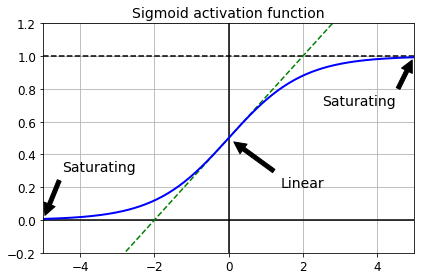

In [4]:
z = np.linspace(-5, 5, 200)

plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [1, 1], 'k--')
plt.plot([0, 0], [-0.2, 1.2], 'k-')
plt.plot([-5, 5], [-3/4, 7/4], 'g--')

plt.plot(z, logit(z), 'b-', linewidth=2)

props = dict(facecolor='black', shrink=0.1)

plt.annotate('Saturating', xytext=(3.5, 0.7), xy=(5, 1),
             arrowprops=props, fontsize=14, ha='center')
plt.annotate('Saturating', xytext=(-3.5, 0.3), xy=(-5, 0), 
             arrowprops=props, fontsize=14, ha="center")
plt.annotate('Linear', xytext=(2, 0.2), xy=(0, 0.5), arrowprops=props, fontsize=14, ha="center")
plt.grid(True)
plt.title("Sigmoid activation function", fontsize=14)
plt.axis([-5, 5, -0.2, 1.2])

save_fig("sigmoid_saturation_plot")
plt.show()

## Xavier and He Initializations

In [5]:
[name for name in dir(keras.initializers) if not name.startswith('_')]

['Constant',
 'GlorotNormal',
 'GlorotUniform',
 'Identity',
 'Initializer',
 'Ones',
 'Orthogonal',
 'RandomNormal',
 'RandomUniform',
 'TruncatedNormal',
 'VarianceScaling',
 'Zeros',
 'constant',
 'deserialize',
 'get',
 'glorot_normal',
 'glorot_uniform',
 'he_normal',
 'he_uniform',
 'identity',
 'lecun_normal',
 'lecun_uniform',
 'ones',
 'orthogonal',
 'serialize',
 'zeros']

In [6]:
keras.layers.Dense(10, activation='relu', kernel_initializer='he_normal')

In [7]:
init = keras.initializers.VarianceScaling(scale=2.,
                                          mode='fan_avg',
                                          distribution='uniform')

In [8]:
keras.layers.Dense(10, activation='relu', kernel_initializer=init)

## Nonsaturating Activation Functions

### Leaky ReLU:

In [9]:
def leaky_relu(z, alpha=0.01):
    return np.maximum(alpha * z, z)

Saving figure leaky_relu_plot


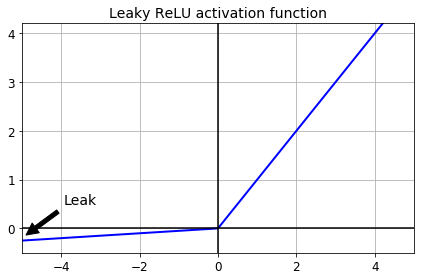

In [10]:
plt.plot(z, leaky_relu(z, 0.05), 'b-', linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([0, 0], [-0.5, 4.2], 'k-')
plt.grid(True)
props = dict(facecolor='black', shrink=0.1)
plt.annotate('Leak', xytext=(-3.5, 0.5), xy=(-5, -0.2), arrowprops=props, fontsize=14, ha="center")
plt.title("Leaky ReLU activation function", fontsize=14)
plt.axis([-5, 5, -0.5, 4.2])

save_fig("leaky_relu_plot")
plt.show()

In [11]:
[m for m in dir(keras.activations) if not m.startswith('_')]

['deserialize',
 'elu',
 'exponential',
 'get',
 'hard_sigmoid',
 'linear',
 'relu',
 'selu',
 'serialize',
 'sigmoid',
 'softmax',
 'softplus',
 'softsign',
 'tanh']

In [12]:
[m for m in dir(keras.layers) if 'relu' in m.lower()]

['LeakyReLU', 'PReLU', 'ReLU', 'ThresholdedReLU']

Let's train a neural network on Fashion MNIST using the Leaky ReLU:

In [13]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()

In [14]:
X_train_full = X_train_full / 255.0
X_test = X_test / 255.0
X_valid, X_train = X_train_full[:5000], X_train_full[5000:]
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]

In [15]:
tf.random.set_seed(42)
np.random.seed(42)

In [16]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(30, kernel_initializer='he_normal'),
    keras.layers.LeakyReLU(),
    keras.layers.Dense(100, kernel_initializer='he_normal'),
    keras.layers.LeakyReLU(),
    keras.layers.Dense(10, activation='softmax')
])

In [17]:
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=keras.optimizers.SGD(lr=1e-3),
              metrics=['accuracy'])

In [18]:
history = model.fit(X_train, y_train,
                    epochs=10,
                    validation_data=(X_valid, y_valid))

Train on 55000 samples, validate on 5000 samples
Epoch 1/10
55000/55000 [==============================] - 2s 41us/sample - loss: 1.3667 - accuracy: 0.5693 - val_loss: 0.9051 - val_accuracy: 0.7082
Epoch 2/10
55000/55000 [==============================] - 2s 41us/sample - loss: 0.8126 - accuracy: 0.7205 - val_loss: 0.7256 - val_accuracy: 0.7500
Epoch 3/10
55000/55000 [==============================] - 2s 33us/sample - loss: 0.6966 - accuracy: 0.7577 - val_loss: 0.6478 - val_accuracy: 0.7772
Epoch 4/10
55000/55000 [==============================] - 2s 38us/sample - loss: 0.6344 - accuracy: 0.7808 - val_loss: 0.5995 - val_accuracy: 0.8028
Epoch 5/10
55000/55000 [==============================] - 2s 33us/sample - loss: 0.5932 - accuracy: 0.7967 - val_loss: 0.5667 - val_accuracy: 0.8096
Epoch 6/10
55000/55000 [==============================] - 2s 34us/sample - loss: 0.5643 - accuracy: 0.8073 - val_loss: 0.5435 - val_accuracy: 0.8172
Epoch 7/10
55000/55000 [==============================] -

### PReLU:

Now let's try PReLU:

In [19]:
tf.random.set_seed(42)
np.random.seed(42)

In [20]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, kernel_initializer="he_normal"),
    keras.layers.PReLU(),
    keras.layers.Dense(100, kernel_initializer="he_normal"),
    keras.layers.PReLU(),
    keras.layers.Dense(10, activation="softmax")
])

In [21]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(lr=1e-3),
              metrics=["accuracy"])

In [22]:
history = model.fit(X_train, y_train,
                    epochs=10,
                    validation_data=(X_valid, y_valid))

Train on 55000 samples, validate on 5000 samples
Epoch 1/10
55000/55000 [==============================] - 5s 86us/sample - loss: 1.3460 - accuracy: 0.6233 - val_loss: 0.9251 - val_accuracy: 0.7208
Epoch 2/10
55000/55000 [==============================] - 5s 84us/sample - loss: 0.8208 - accuracy: 0.7359 - val_loss: 0.7318 - val_accuracy: 0.7628
Epoch 3/10
55000/55000 [==============================] - 4s 77us/sample - loss: 0.6974 - accuracy: 0.7695 - val_loss: 0.6500 - val_accuracy: 0.7888
Epoch 4/10
55000/55000 [==============================] - 4s 79us/sample - loss: 0.6339 - accuracy: 0.7903 - val_loss: 0.6001 - val_accuracy: 0.8068
Epoch 5/10
55000/55000 [==============================] - 4s 80us/sample - loss: 0.5920 - accuracy: 0.8045 - val_loss: 0.5661 - val_accuracy: 0.8174
Epoch 6/10
55000/55000 [==============================] - 4s 74us/sample - loss: 0.5620 - accuracy: 0.8138 - val_loss: 0.5417 - val_accuracy: 0.8230
Epoch 7/10
55000/55000 [==============================] -

### ELU:

The exponential linear unit(ELU):

In [23]:
def elu(z, alpha=1):
    return np.where(z < 0, alpha * (np.exp(z) - 1), z)

Saving figure elu_plot


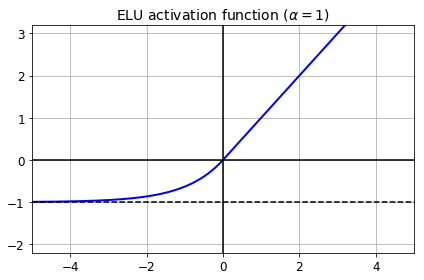

In [24]:
plt.plot(z, elu(z), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [-1, -1], 'k--')
plt.plot([0, 0], [-2.2, 3.2], 'k-')
plt.grid(True)
plt.title(r"ELU activation function ($\alpha=1$)", fontsize=14)
plt.axis([-5, 5, -2.2, 3.2])

save_fig("elu_plot")
plt.show()

Implementing ELU in TensorFlow is trivial, just specify the activation function when building each layer:

In [25]:
keras.layers.Dense(10, activation='elu')

### SELU:

This activation function was proposed in this great paper by Günter Klambauer, Thomas Unterthiner and Andreas Mayr, published in June 2017. During training, a neural network composed exclusively of a stack of dense layers using the SELU activation function and LeCun initialization will self-normalize: the output of each layer will tend to preserve the same mean and variance during training, which solves the vanishing/exploding gradients problem. As a result, this activation function outperforms the other activation functions very significantly for such neural nets, so you should really try it out. Unfortunately, the self-normalizing property of the SELU activation function is easily broken: you cannot use ℓ1 or ℓ2 regularization, regular dropout, max-norm, skip connections or other non-sequential topologies (so recurrent neural networks won't self-normalize). However, in practice it works quite well with sequential CNNs. If you break self-normalization, SELU will not necessarily outperform other activation functions.

In [26]:
from scipy.special import erfc

In [27]:
# alpha and scale to self normalize with mean 0 and standard deviation 1
# (see equation 14 in the paper):
alpha_0_1 = -np.sqrt(2 / np.pi) / (erfc(1/np.sqrt(2)) * np.exp(1/2) - 1)
scale_0_1 = (1 - erfc(1 / np.sqrt(2)) * np.sqrt(np.e)) * np.sqrt(2 * np.pi) * (2 * erfc(np.sqrt(2))*np.e**2 + np.pi*erfc(1/np.sqrt(2))**2*np.e - 2*(2+np.pi)*erfc(1/np.sqrt(2))*np.sqrt(np.e)+np.pi+2)**(-1/2)

In [28]:
def selu(z, scale=scale_0_1, alpha=alpha_0_1):
    return scale * elu(z, alpha)

Saving figure selu_plot


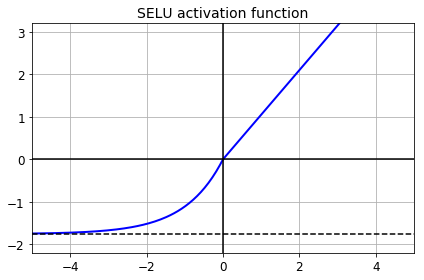

In [29]:
plt.plot(z, selu(z), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [-1.758, -1.758], 'k--')
plt.plot([0, 0], [-2.2, 3.2], 'k-')
plt.grid(True)
plt.title("SELU activation function", fontsize=14)
plt.axis([-5, 5, -2.2, 3.2])

save_fig("selu_plot")
plt.show()

By default, the SELU hyperparameters (`scale` and `alpha`) are tuned in such a way that the mean output of each neuron remains close to 0, and the standard deviation remains close to 1 (assuming the inputs are standardized with mean 0 and standard deviation 1 too). Using this activation function, even a 1,000 layer deep neural network preserves roughly mean 0 and standard deviation 1 across all layers, avoiding the exploding/vanishing gradients problem:

In [30]:
np.random.seed(42)
Z = np.random.normal(size=(500, 100)) # standardized inputs
for layer in range(1000):
    W = np.random.normal(size=(100, 100), scale=np.sqrt(1 / 100)) # LeCun initialization
    Z = selu(np.dot(Z, W))
    means = np.mean(Z, axis=0).mean()
    stds = np.std(Z, axis=0).mean()
    if layer % 100 == 0:
        print("Layer {}: mean {:.2f}, std deviation {:.2f}".format(layer, means, stds))

Layer 0: mean -0.00, std deviation 1.00
Layer 100: mean 0.02, std deviation 0.96
Layer 200: mean 0.01, std deviation 0.90
Layer 300: mean -0.02, std deviation 0.92
Layer 400: mean 0.05, std deviation 0.89
Layer 500: mean 0.01, std deviation 0.93
Layer 600: mean 0.02, std deviation 0.92
Layer 700: mean -0.02, std deviation 0.90
Layer 800: mean 0.05, std deviation 0.83
Layer 900: mean 0.02, std deviation 1.00


Using SELU is easy:

In [31]:
keras.layers.Dense(10, activation="selu",
                   kernel_initializer="lecun_normal")

Let's create a neural net for Fashion MNIST with 100 hidden layers, using the SELU activation function:

In [32]:
np.random.seed(42)
tf.random.set_seed(42)

In [33]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation='selu',
                       kernel_initializer='lecun_normal')
])

In [34]:
for layer in range(99):
    model.add(keras.layers.Dense(100, activation='selu',
                                 kernel_initializer='lecun_normal'))

In [35]:
model.add(keras.layers.Dense(10, activation='softmax'))

In [36]:
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=keras.optimizers.SGD(lr=1e-3),
              metrics=['accuracy'])

Now let's train it. Do not forget to scale the inputs to mean 0 and standard deviation 1:

In [37]:
pixel_means = X_train.mean(axis=0, keepdims=True)
pixel_stds = X_train.std(axis=0, keepdims=True)

In [38]:
X_train_scaled = (X_train - pixel_means) / pixel_stds
X_valid_scaled = (X_valid - pixel_means) / pixel_stds
X_test_scaled = (X_test - pixel_means) / pixel_stds

In [39]:
history = model.fit(X_train_scaled, y_train,
                    epochs=5,
                    validation_data=(X_valid_scaled, y_valid))

Train on 55000 samples, validate on 5000 samples
Epoch 1/5
55000/55000 [==============================] - 31s 565us/sample - loss: 1.0197 - accuracy: 0.6154 - val_loss: 0.7386 - val_accuracy: 0.7348
Epoch 2/5
55000/55000 [==============================] - 26s 470us/sample - loss: 0.7149 - accuracy: 0.7401 - val_loss: 0.6187 - val_accuracy: 0.7774
Epoch 3/5
55000/55000 [==============================] - 26s 468us/sample - loss: 0.6193 - accuracy: 0.7803 - val_loss: 0.5926 - val_accuracy: 0.8036
Epoch 4/5
55000/55000 [==============================] - 26s 477us/sample - loss: 0.5555 - accuracy: 0.8043 - val_loss: 0.5208 - val_accuracy: 0.8262
Epoch 5/5
55000/55000 [==============================] - 27s 483us/sample - loss: 0.5159 - accuracy: 0.8238 - val_loss: 0.4790 - val_accuracy: 0.8358


Now look at what happens if we try to use the ReLU activation function instead:

In [40]:
np.random.seed(42)
tf.random.set_seed(42)

In [41]:
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[28, 28]))
model.add(keras.layers.Dense(300, activation="relu", kernel_initializer="he_normal"))

In [42]:
for layer in range(99):
    model.add(keras.layers.Dense(100, activation="relu", kernel_initializer="he_normal"))
model.add(keras.layers.Dense(10, activation="softmax"))

In [43]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(lr=1e-3),
              metrics=["accuracy"])

In [44]:
history = model.fit(X_train_scaled, y_train, 
                    epochs=5,
                    validation_data=(X_valid_scaled, y_valid))

Train on 55000 samples, validate on 5000 samples
Epoch 1/5
55000/55000 [==============================] - 18s 325us/sample - loss: 1.9174 - accuracy: 0.2242 - val_loss: 1.3856 - val_accuracy: 0.3846
Epoch 2/5
55000/55000 [==============================] - 17s 305us/sample - loss: 1.2147 - accuracy: 0.4750 - val_loss: 1.0691 - val_accuracy: 0.5510
Epoch 3/5
55000/55000 [==============================] - 17s 307us/sample - loss: 0.9576 - accuracy: 0.6025 - val_loss: 0.7688 - val_accuracy: 0.7036
Epoch 4/5
55000/55000 [==============================] - 17s 312us/sample - loss: 0.8116 - accuracy: 0.6762 - val_loss: 0.7276 - val_accuracy: 0.7288
Epoch 5/5
55000/55000 [==============================] - 18s 320us/sample - loss: 0.8167 - accuracy: 0.6862 - val_loss: 0.7697 - val_accuracy: 0.7032


## Batch Normalization

In [45]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(300, activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(100, activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(10, activation='softmax')
])

In [46]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_4 (Flatten)          (None, 784)               0         
_________________________________________________________________
batch_normalization_v2 (Batc (None, 784)               3136      
_________________________________________________________________
dense_212 (Dense)            (None, 300)               235500    
_________________________________________________________________
batch_normalization_v2_1 (Ba (None, 300)               1200      
_________________________________________________________________
dense_213 (Dense)            (None, 100)               30100     
_________________________________________________________________
batch_normalization_v2_2 (Ba (None, 100)               400       
_________________________________________________________________
dense_214 (Dense)            (None, 10)               

In [47]:
bn1 = model.layers[1]

[(var.name, var.trainable) for var in bn1.variables]

[('batch_normalization_v2/gamma:0', True),
 ('batch_normalization_v2/beta:0', True),
 ('batch_normalization_v2/moving_mean:0', False),
 ('batch_normalization_v2/moving_variance:0', False)]

In [48]:
bn1.updates

ListWrapper([<tf.Operation 'batch_normalization_v2/cond_2/Identity' type=Identity>, <tf.Operation 'batch_normalization_v2/cond_3/Identity' type=Identity>])

In [49]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(lr=1e-3),
              metrics=["accuracy"])

In [50]:
history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_valid, y_valid))

Train on 55000 samples, validate on 5000 samples
Epoch 1/10
55000/55000 [==============================] - 7s 122us/sample - loss: 0.8756 - accuracy: 0.7140 - val_loss: 0.5514 - val_accuracy: 0.8212
Epoch 2/10
55000/55000 [==============================] - 6s 112us/sample - loss: 0.5765 - accuracy: 0.8033 - val_loss: 0.4742 - val_accuracy: 0.8436
Epoch 3/10
55000/55000 [==============================] - 6s 115us/sample - loss: 0.5146 - accuracy: 0.8216 - val_loss: 0.4382 - val_accuracy: 0.8530
Epoch 4/10
55000/55000 [==============================] - 6s 114us/sample - loss: 0.4821 - accuracy: 0.8322 - val_loss: 0.4170 - val_accuracy: 0.8604
Epoch 5/10
55000/55000 [==============================] - 6s 110us/sample - loss: 0.4589 - accuracy: 0.8402 - val_loss: 0.4003 - val_accuracy: 0.8658
Epoch 6/10
55000/55000 [==============================] - 6s 109us/sample - loss: 0.4428 - accuracy: 0.8459 - val_loss: 0.3883 - val_accuracy: 0.8698
Epoch 7/10
55000/55000 [===========================

## Gradient Clipping

All Keras optimizers accept `clipnorm` or `clipvalue` arguments:

In [51]:
optimizer = keras.optimizers.SGD(clipvalue=1.0)

In [52]:
optimizer = keras.optimizers.SGD(clipnorm=1.0)